<a href="https://colab.research.google.com/github/hazelliang/Python-Machine-Learning-Project/blob/master/Recommendation%20system%20-%20Amazon%20Fine%20Food%20Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews

Dataset resource: https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

## Ingest

In [0]:
!pip install -q scikit-surprise

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
path = "/content/drive"
os.chdir(path)
os.listdir(path)
print(os.getcwd())

/content/drive


In [0]:
import pandas as pd

df = pd.read_csv('My Drive/BAX 452/HW 7/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## EDA

### Product/User

In [0]:
df[['ProductId','UserId']].describe()

,ProductId,UserId
count,568454,568454
unique,74258,256059
top,B007JFMH8M,A3OXHLG6DIBRW8
freq,913,448


### Score distribution

In [0]:
!pip uninstall -q -y plotly
!pip install -q plotly
!pip install -q --upgrade cufflinks

In [0]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

In [0]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [0]:
import cufflinks as cf
cf.go_offline()
from plotly.offline import init_notebook_mode
configure_plotly_browser_state()
init_notebook_mode(connected=False)


data = df['Score'].value_counts().sort_index(ascending=False)

trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000001'),
               y = data.values,
               )

layout = dict(title = 'Distribution Of {} Amazon-Reviews'.format(df.shape[0]),
              xaxis = dict(title = 'Score'),
              yaxis = dict(title = 'Count'))

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Review summary of different scores

In [0]:
import re
import string
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
summary = df.groupby("Score")["Summary"].apply(list)

In [0]:
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

In [0]:
summary = pd.DataFrame(summary)
summary.to_csv("My Drive/BAX 452/HW 7/summary.csv")
summary1 = pd.read_csv("My Drive/BAX 452/HW 7/summary.csv")

In [0]:
summary1["Summary_Clean"] = summary1["Summary"].apply(cleanup)

In [0]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

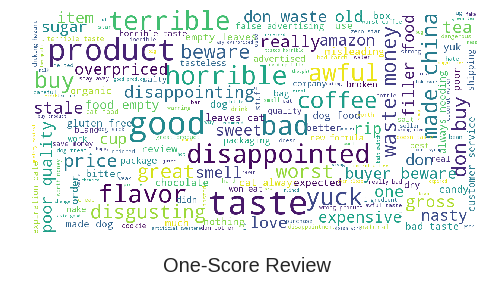

In [0]:
show_wordcloud(summary1["Summary_Clean"][0], title = "One-Score Review")

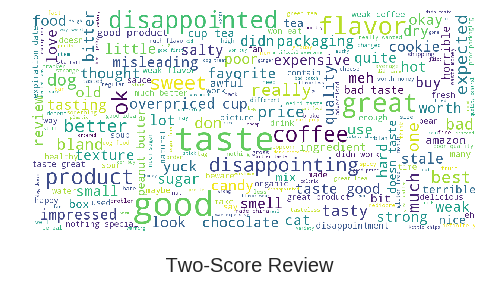

In [0]:
show_wordcloud(summary1["Summary_Clean"][1] , title = " Two-Score Review")

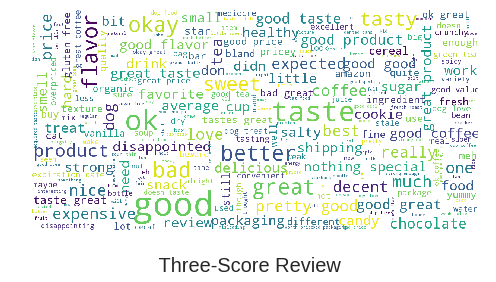

In [0]:
show_wordcloud(summary1["Summary_Clean"][2] , title = " Three-Score Review")

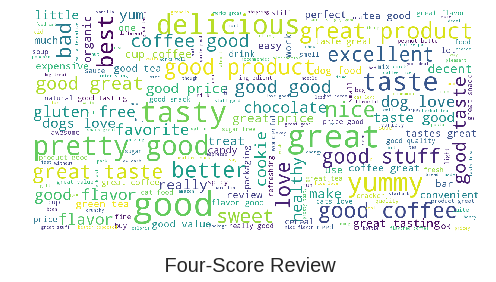

In [0]:
show_wordcloud(summary1["Summary_Clean"][3] , title = " Four-Score Review")

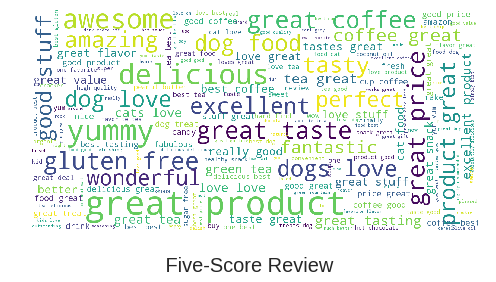

In [0]:
show_wordcloud(summary1["Summary_Clean"][4] , title = " Five-Score Review")

## Modeling

### Compare surprise algorithms with 3-fold crossvalidation

In [0]:
import surprise as sp
from surprise.model_selection import cross_validate

data = sp.Dataset.load_from_df(df[['UserId','ProductId','Score']].sample(20000), sp.Reader())

benchmark = []
# Iterate over all algorithms
for algorithm in [sp.SVD(), sp.SVDpp(), sp.SlopeOne(), sp.NMF(), sp.NormalPredictor(), sp.KNNBaseline(), sp.KNNBasic(), sp.KNNWithMeans(), sp.KNNWithZScore(), sp.BaselineOnly(), sp.CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    
    # Store data
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [0]:
configure_plotly_browser_state()

# Store results
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse', ascending=False)

# Get data
data = surprise_results[['test_rmse', 'test_mae']]
grid = data.values

# Create axis labels
x_axis = [label.split('_')[1].upper() for label in data.columns.tolist()]
y_axis = data.index.tolist()

x_label = 'Function'
y_label = 'Algorithm'


# Get annotations and hovertext
hovertexts = []
annotations = []
for i, y_value in enumerate(y_axis):
    row = []
    for j, x_value in enumerate(x_axis):
        annotation = grid[i, j]
        row.append('Error: {:.3f}<br>{}: {}<br>{}: {}<br>Fit Time: {:.3f}s<br>Test Time: {:.3f}s'.format(annotation, y_label, y_value ,x_label, x_value, surprise_results.loc[y_value]['fit_time'], surprise_results.loc[y_value]['test_time']))
        annotations.append(dict(x=x_value, y=y_value, text='{:.3f}'.format(annotation), ax=0, ay=0, font=dict(color='#000000')))
    hovertexts.append(row)

# Create trace
trace = go.Heatmap(x = x_axis,
                   y = y_axis,
                   z = data.values,
                   text = hovertexts,
                   hoverinfo = 'text',
                   colorscale = 'Picnic',
                   colorbar = dict(title = 'Error'))

# Create layout
layout = go.Layout(title = 'Crossvalidated Comparison Of Surprise Algorithms',
                   xaxis = dict(title = x_label),
                   yaxis = dict(title = y_label,
                                tickangle = -40),
                   annotations = annotations)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### KNN Item-based

In [0]:
from surprise import KNNBaseline, Reader, Dataset

data = sp.Dataset.load_from_df(df[['UserId','ProductId','Score']].sample(10000), sp.Reader())
trainset = data.build_full_trainset()
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBaseline(sim_options=sim_options)
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
userid = str('A3SGXH7AUHU8GW')
itemid = str('B001E4KFG0')
actual_rating = 5
print(algo.predict(userid, itemid, actual_rating))

user: A3SGXH7AUHU8GW item: B001E4KFG0 r_ui = 5.00   est = 4.20   {'was_impossible': False}


### SVD recommender

In [0]:
from collections import defaultdict

from surprise import Reader, Dataset, SVD

In [0]:
def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [0]:
reader = Reader()

data = Dataset.load_from_df(df[['UserId', 'ProductId', 'Score']].sample(2000), reader)
trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n=10)

In [0]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

AHKJI749XNJOG ['B007RLRCLK', 'B000H1217M', 'B003TNANSO', 'B000N62EKK', 'B000CQ26EK', 'B001BS4G6O', 'B004O6JE26', 'B000CQID2Y', 'B005HG9ERW', 'B000LKU3DI']
A3JEP8LHMGRMNH ['B000H7EE26', 'B00008Q3B7', 'B002QWHJOU', 'B000CSKKG4', 'B000EMQF2G', 'B003TNANSO', 'B001RVFERK', 'B000CQG87Q', 'B0029NVJNI', 'B000AYDHD8']
A2T5VEAFT6PUH3 ['B002QWHJOU', 'B0006Z7NOK', 'B003D4MYLS', 'B006AA5JKA', 'B001ELL3DM', 'B000YDIXDO', 'B000ED7M6I', 'B0014C6O44', 'B003V8SO10', 'B005K4Q4LK']
A1X3P1800K6HT0 ['B005CJBKAI', 'B0014WYXYW', 'B001SAXPEO', 'B001RVFDOO', 'B006DQZ04Q', 'B002YJ0118', 'B0061PPLYI', 'B0044MTGHI', 'B002QWHJOU', 'B006VRTQW4']
AYWUHB7N8XGZQ ['B000CQC064', 'B0032B0BD0', 'B008RWUKXK', 'B000I5DK04', 'B001ET5Y52', 'B000VIFCYU', 'B001GQ3E3M', 'B000G6RYNE', 'B002QWHJOU', 'B00022EWFK']
A39D7ONPOORMUT ['B003TNANSO', 'B0000ESTGY', 'B003CK7O36', 'B0019QT66I', 'B0034EDMLI', 'B000VKYMUS', 'B000CQ4D50', 'B004O6JE26', 'B00384NZTI', 'B000FW0NIC']
A852I21I0KLM0 ['B0000CH39R', 'B0000W2SZS', 'B000WVYB8Y', 'B000HK9I

## Conclusion

* In our dataset, we have 568,454 reviews, 74,258 products and 256,059 users. Item B007JFMH8M got the most reviews (913). User A3OXHLG6DIBRW8 has left the most amount of reviews (448).

*	63.9% of the reviews are 5-score.

* For higher score reviews, they are about good price, great tasting and high quality. On the contrary, for lower score reviews, people complain about overpriced, misleading information, bad tastes and poor quality. 

* We utilized KNNBaseline and SVD to build our recommendation system. For KNNBaseline, our model can predict a specific user's rating of a specific item. For SVD, our model can recommend top-10 items for each user.



